In [22]:
!pip install scikeras

In [23]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from PIL import Image
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

import keras
import scikeras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report

In [24]:
@tf.custom_gradient
def O2RU(x):
    r=2
    g =  r*(r**2 * K.abs(x) + 1)**((1-r)/r)
    def grad(dy):
      return dy * g
    return K.sign(x)*((r**2 * K.abs(x) + 1)**(1/r) - 1), grad

@tf.custom_gradient
def O3RU(x):
    r=3
    g =  r*(r**2 * K.abs(x) + 1)**((1-r)/r)
    def grad(dy):
      return dy * g
    return K.sign(x)*((r**2 * K.abs(x) + 1)**(1/r) - 1), grad

with tf.GradientTape() as g:
  x = tf.constant([0.0])
  g.watch(x)
  y = O3RU(x)
dy_dx = g.gradient(y, x)
print(dy_dx)

@tf.custom_gradient
def E1RU(x):
  r = 1
  gradient = tf.where(x >= 0, r*(r**2 * x + 1)**((1-r)/r), r*K.exp(r*x))
  def grad(dy):
      return dy * gradient
  return tf.where(x >= 0, (r**2 * x + 1)**(1/r) - 1/r, K.exp(r*x) - 1/r), grad

@tf.custom_gradient
def E2RU(x):
  r = 2
  gradient = tf.where(x >= 0, r*(r**2 * x + 1)**((1-r)/r), r*K.exp(r*x))
  def grad(dy):
      return dy * gradient
  return tf.where(x >= 0, (r**2 * x + 1)**(1/r) - 1/r, K.exp(r*x) - 1/r), grad

@tf.custom_gradient
def E3RU(x):
  r = 3
  gradient = tf.where(x >= 0, r*(r**2 * x + 1)**((1-r)/r), r*K.exp(r*x))
  def grad(dy):
      return dy * gradient
  return tf.where(x >= 0, (r**2 * x + 1)**(1/r) - 1/r, K.exp(r*x) - 1/r), grad

with tf.GradientTape() as g:
  x = tf.constant([-5.0,0.0,5.0,10.0,100.0])
  g.watch(x)
  y = E2RU(x)
dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor([3.], shape=(1,), dtype=float32)
tf.Tensor([9.0799862e-05 2.0000000e+00 4.3643579e-01 3.1234753e-01 9.9875227e-02], shape=(5,), dtype=float32)


In [25]:
folder_benign_train = '/content/drive/MyDrive/CNN skin cancer/train/benign'
folder_malignant_train = '/content/drive/MyDrive/CNN skin cancer/train/malignant'

folder_benign_test = '/content/drive/MyDrive/CNN skin cancer/test/benign'
folder_malignant_test = '/content/drive/MyDrive/CNN skin cancer/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Ładowanie plików treningowych
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Ładowanie plików testowych
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Tworzenie oznaczeń
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Łączenie danych z oznaczeniami
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Losowanie danych
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]


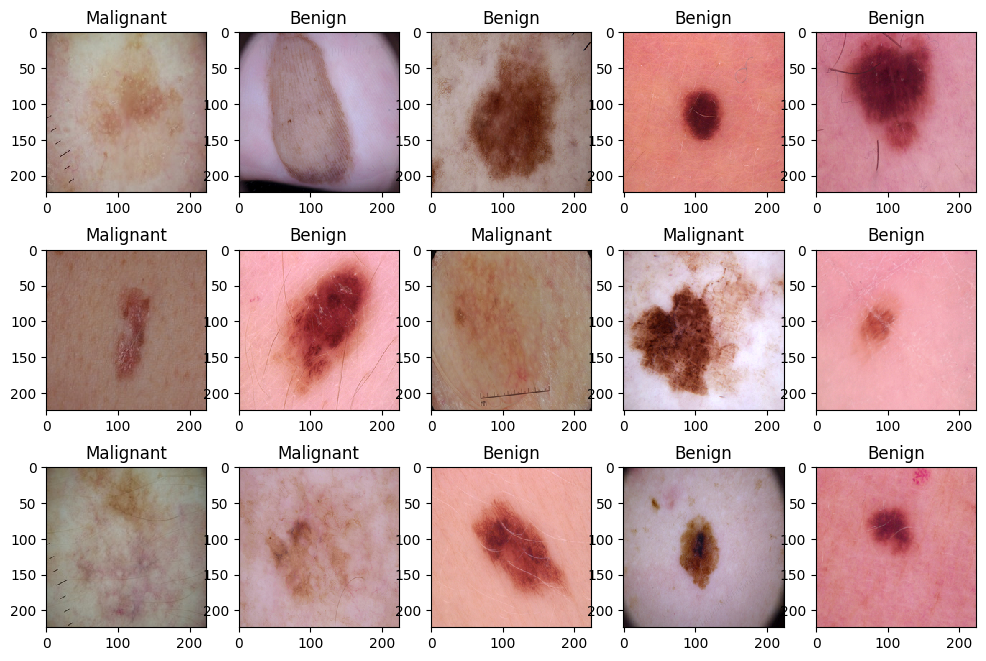

In [26]:
# Wyświetl pierwsze 15 zdjęć oraz ich oznaczenia
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [27]:
# Kodowanie One-Hot dla oznaczeń
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [28]:
# Argumentacja danych aby zapobiec nadmiernu dopasowaniu
X_train = X_train/255.
X_test = X_test/255.

In [29]:
def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= E2RU, optim= Adam(learning_rate=0.0001)):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= E2RU, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',
                     activation = E2RU, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation= E2RU, kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    model.compile(optimizer = Adam(learning_rate=0.0001) ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Ustaw "odprężacz" współczynniku uczenia
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000005)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 56, 56, 64)       

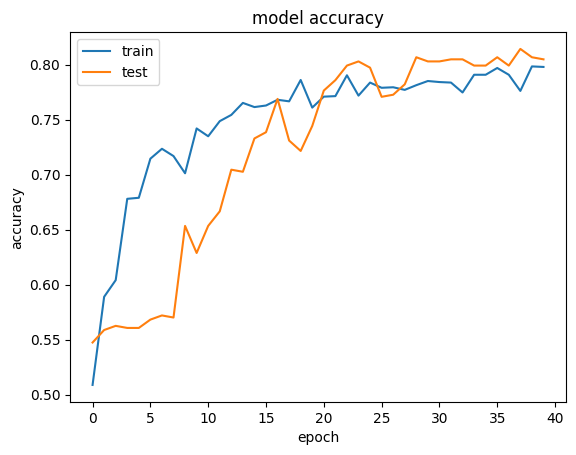

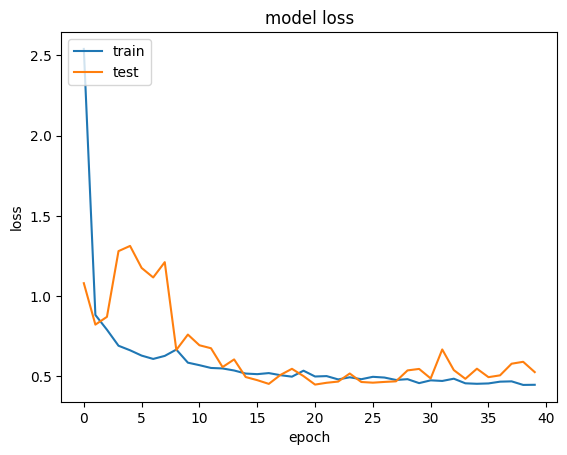

In [30]:
input_shape = (224,224,3)
lr = 0.0001
init = 'normal'
activ = E2RU
optim = 'Adam'
epochs = 40
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim= optim, input_shape= input_shape)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1,
                    callbacks=[learning_rate_reduction]
                   )

# Wypisz całą date w wartości "history"
print(history.history.keys())
# Streść historie na dokładność
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Streść historie na utrate
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
# Przetestuj model na danych testowych
predict_prob=model.predict([X_test])
predict_classes=np.argmax(predict_prob,axis=1)
print(predict_classes)
# Klasyfikacja danych testowych
y_test_label = np.argmax(y_test, axis=1)
# Wypisz kształt
print(y_test_label.shape, predict_classes.shape)
# Tworzenie raportu klasyfikacji dla danych testowych
print(classification_report(y_test_label, predict_classes))

21/21 [==============================] - 1s 69ms/step
[1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1
 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1
 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1
 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1
 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1
 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0
 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1
 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0
 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0
 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0
 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0

In [ ]:
model_name = 'CNN'
subject = 'Skin Cancer'
save_path = ''

# Zapisz model
save_id = str({model_name})
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'Model zapisany jako: {model_save_loc}')

# Zapisz wagi modelu
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'Wagi modelu zapisano jako {weights_save_loc}')

model was saved as {'conv2d'}
weights were saved as conv2d-Skin Cancer-weights.h5
